In [18]:
import cv2
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
import os
import matplotlib.pyplot as plt
y = mx+b
y-b / m

In [2]:
def getROICorners(GT_df, frame_index, max_width=375):
    
    #max_width = 375
    max_y = 720 # represents floor in front
    min_y = 150 # represents "horizon"
    slope = max_width / (max_y-min_y)
    point_count = GT_df["#ofPoints"][frame_index]
    frame_points = GT_df.iloc[frame_index, 3:(3+point_count*2)]
    Xlist = []
    Ylist = []
    
    # iterate through each point using the y-value
    for i in range(1, point_count*2, 2):
        # This linear equation serves as a base
        #print(frame_points[i])
        if i == 1 and frame_points[i] != 720:
            frame_points[i] = 720
        if frame_points[i] == 0 and frame_points[i-1] == 0:
            continue
        if frame_points[i] < min_y and i != 1:
            x1 = frame_points[i-3]
            y1 = frame_points[i-2]
            x2 = frame_points[i-1]
            y2 = frame_points[i]
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope * x1
            new_x = (min_y-intercept) / slope
            frame_points[i-1] = new_x
            frame_points[i] = min_y
            continue
        width = max_width - (max_y-frame_points[i]) * slope
        width = int(width//2)
        if frame_points[i-1]+width > 1280:
            Xlist.append(1275)
        else:
            Xlist.append(frame_points[i-1]+width)
        Ylist.append(frame_points[i])
        if frame_points[i-1]-width < 0:
            Xlist.append(0)
        else:
            Xlist.append(frame_points[i-1]-width)
        Ylist.append(frame_points[i])
    return Xlist, Ylist

In [3]:
def calculate_iou(polygon1, polygon2):
    # Clean the polygons to fix any self-intersection issues
    clean_polygon1 = polygon1.buffer(0)
    clean_polygon2 = polygon2.buffer(0)

    # Calculate the intersection and union of the cleaned polygons
    intersection_area = clean_polygon1.intersection(clean_polygon2).area
    union_area = clean_polygon1.union(clean_polygon2).area


    # Check if the union area is zero
    if union_area == 0:
        iou = 0  # Handle the case where there is no union
    else:
        # Calculate the IoU
        iou = intersection_area / union_area
        iou = intersection_area / union_area

    return iou

In [4]:
def list_files(folder_path):
    # Get a list of all files in the folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    return files

In [5]:
def getVideoIoU(df1, df2, total_frames, fileName, max_width=375):
    total_iou = 0
    frame_count = total_frames
    for frame_index in range(total_frames):
        "    #print(frame_index)\n",
        Xlist1, Ylist1 = getROICorners(df1, frame_index, max_width)
        Xlist2, Ylist2 = getROICorners(df2, frame_index, max_width)
        points1 = []
        for point in range(0, len(Xlist1), 2):
            points1.append( (Xlist1[point],Ylist1[point]) )
        for point in reversed(range(1, len(Xlist1), 2)):
            points1.append( (Xlist1[point],Ylist1[point]) )
        points2 = []
        for point in range(0, len(Xlist2), 2):
            points2.append( (Xlist2[point],Ylist2[point]) )
        for point in reversed(range(1, len(Xlist2), 2)):
            points2.append( (Xlist2[point],Ylist2[point]) )
        if len(points2)<4 or len(points1)<4:
            frame_count -= 1
            continue
        polygon1 = Polygon(points1)
        polygon2 = Polygon(points2)
        total_iou += calculate_iou(polygon1, polygon2)
    #print(fileName+" IoU = ", end="")
    #print(total_iou/frame_count)
    #print(frame_count)
    return total_iou/frame_count

In [6]:
locationList = ["L4", "L5", "L6", "L7", "L8", "L9", "L10", "L11", "L12", "L13", "L14", "L15", "L16", "L17", "L18", "L19", "L20", "L21","L22", "L23"]
videoFolderPath = r"C:\Users\Jimmy\Documents\Experimental_Forest\VideoData720p\Location 4 - Experimental Forest"
GT1RootPath = r"C:\Users\Jimmy\Downloads\GroundTruthLabelsJimmy\\"
GT2RootPath = r"C:\Users\Jimmy\Downloads\GroundTruthLabelsPranava\\"
GT1FolderPath = GT1RootPath + locationList[0]
GT2FolderPath = GT2RootPath + locationList[0]
GTFiles = list_files(GT1FolderPath)
#print(GTFiles)
videoName = GTFiles[0][:-7] + ".mp4"

In [9]:
test_widths = [*range(100, 625, 25)]
IoU_for_width = []
print(len(test_widths))

21


In [8]:
for width in test_widths:
    print("Analyzing with width: {}".format(width))
    locationIoU = 0
    totalIoU = 0
    for location in locationList:
        #print("Analyzing "+location)
        GT1FolderPath = GT1RootPath + location
        GT2FolderPath = GT2RootPath + location
        GTFiles = list_files(GT1FolderPath)
        locationIoU = 0
        for file in range(len(GTFiles)):
            GT1Location = GT1FolderPath+"\\"+GTFiles[file]
            GT2Location = GT2FolderPath+"\\"+GTFiles[file]
            df1 = pd.read_csv(GT1Location)
            df2 = pd.read_csv(GT2Location)
            total_frames = df1.shape[0]-1
            videoName = GTFiles[file][:-7] + ".mp4"
            locationIoU += getVideoIoU(df1, df2, total_frames, videoName, width)
        locationIoU /= len(GTFiles)
        #print("LocationIoU = ",end="")
        #print(locationIoU)
        totalIoU += locationIoU
    totalIoU /= len(locationList)
    print("For width {} total IoU = {}".format(width, totalIoU))
    IoU_for_width[width] = totalIoU 
    #print(totalIoU)

Analyzing with width: 100
For width 100 total IoU = 0.3180134668477351
Analyzing with width: 125
For width 125 total IoU = 0.3743598011280417
Analyzing with width: 150
For width 150 total IoU = 0.42198413238115917
Analyzing with width: 175
For width 175 total IoU = 0.46233507196721285
Analyzing with width: 200
For width 200 total IoU = 0.4969774571974802
Analyzing with width: 225
For width 225 total IoU = 0.5270664823206069
Analyzing with width: 250
For width 250 total IoU = 0.5534962183576129
Analyzing with width: 275
For width 275 total IoU = 0.5768589075467951
Analyzing with width: 300
For width 300 total IoU = 0.5976598593559602
Analyzing with width: 325
For width 325 total IoU = 0.6162018744942583
Analyzing with width: 350
For width 350 total IoU = 0.632906643906917
Analyzing with width: 375
For width 375 total IoU = 0.647997909263281
Analyzing with width: 400
For width 400 total IoU = 0.6617179907143377
Analyzing with width: 425
For width 425 total IoU = 0.6742338291004948
Analyz

In [17]:
IoUValues = [0.3180134668477351, 0.3743598011280417, 0.42198413238115917, 0.46233507196721285, 
            0.4969774571974802, 0.5270664823206069, 0.5534962183576129, 0.5768589075467951,
            0.5976598593559602, 0.6162018744942583, 0.632906643906917, 0.647997909263281,
            0.6617179907143377, 0.6742338291004948, 0.6857229028456628, 0.6963145189205071,
            0.706067831739511, 0.7147367245638805, 0.7231847348024983, 0.7310564528397792,
            0.7384306977929495]

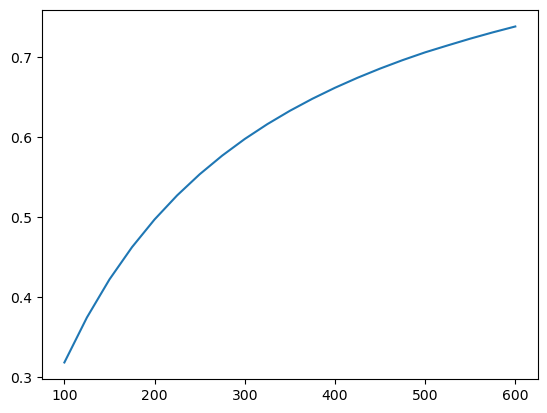

In [20]:
xpoints = np.array(test_widths)
ypoints = np.array(IoUValues)
plt.plot(xpoints, ypoints)
plt.show()